<span style="font-size:22px;">***- Download Data (Positive images, cracked concrete)***.</span>

In [ ]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

In [ ]:
!unzip -q Positive_tensors.zip 

<span style="font-size:22px;">***- Download Data (Negative images, no cracked concrete)***.</span>

In [ ]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip

In [ ]:
!unzip -q Negative_tensors.zip

In [ ]:
!pip install h5py

In [63]:
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

<span style="font-size:22px;">***- Create Dataset Constructor***.</span>

In [64]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/home/bruno/DeepLearning_PyTorch"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


<span style="font-size:22px;">***- Separate data into training and validation***.</span>

In [65]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


<span style="font-size:22px;">***- Import RESNET18 model with pretrained weights***.</span>

In [66]:
model = models.resnet18(pretrained=True)

/home/bruno/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bruno/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<span style="font-size:22px;">***- Make model weights and biases to be fixed***.</span>

In [67]:
count = 0
for param in model.parameters():
    count += 1
    param.requires_grad = False
    
print(count)

62


In [68]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<span style="font-size:22px;">***- Update the output layer to have two outputs***.</span>

In [69]:
model.fc = nn.Linear(512, 2) #weights and biases are not fixed for the created layer

In [70]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<span style="font-size:22px;">***- Define Loss function***.</span>

In [71]:
criterion = nn.CrossEntropyLoss()

<span style="font-size:22px;">***- Create dataloader for training and validation data***.</span>

In [72]:
train_loader = DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100)

<span style="font-size:22px;">***- Set it up to train using GPU***.</span>

In [73]:
torch.cuda.is_available()
device = torch.device('cuda:0')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<span style="font-size:22px;">***- Define optimizer to have parameter updated only on the last layer***.</span>

In [74]:
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=0.001)

<span style="font-size:22px;">***- Model training and evaluation***.</span>

In [75]:
n_epochs = 1
accuracy_list = []
Loss_list = []
N_test = len(validation_dataset)
N_train = len(train_dataset)
start_time = time.time()
#n_epochs


start_time = time.time()
for epoch in range(n_epochs):
    loss_list = []
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        model.train() 
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        model_train = model(x)
        # calculate loss 
        loss = criterion(model_train, y)
        # calculate gradients of parameters 
        loss.backward()        
        # update parameters 
        optimizer.step()
        loss_list.append(loss.data)
    Loss = sum(loss_list) / N_train
    Loss_list.append(Loss)
    correct=0
    
    for x_test, y_test in validation_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        # set model to eval 
        model.eval()
        #make a prediction 
        model_test = model(x_test)
        #find max 
        value, prediction = torch.max(model_test, 1)
        
        #Calculate misclassified  samples in mini-batch 
        correct +=(prediction==y_test).sum().item()
        
   
    accuracy = correct / N_test
    print("Epoch: ", epoch + 1, " Loss: ", float(Loss.cpu().numpy()), " Accuracy: ", accuracy )

Epoch:  1  Loss:  0.0007917176117189229  Accuracy:  0.9925


In [76]:
float(Loss.cpu().numpy())

0.0007917176117189229

In [77]:
loss_list_cpu = [loss.cpu() for loss in loss_list]

<span style="font-size:22px;">***- Loss function analysis***.</span>

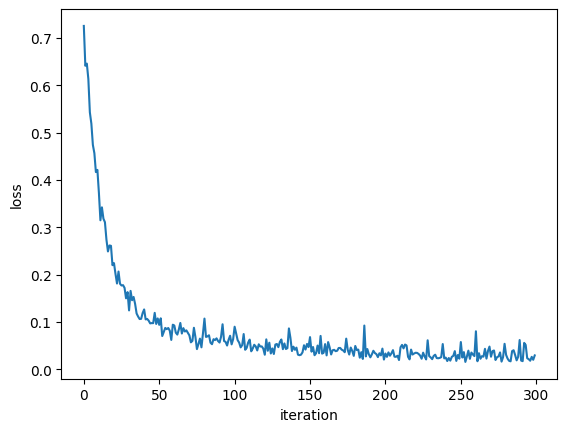

In [78]:
plt.plot(loss_list_cpu)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

<span style="font-size:22px;">***- Accuracy***.</span>

In [79]:
print(accuracy)

0.9925


<span style="font-size:22px;">***- First 4 misclassified samples from validation dataset***.</span>

In [80]:
validation_loader_new = DataLoader(dataset=validation_dataset, batch_size=1)

In [85]:
var = 0
list_index = []
for x_val, y_val in validation_loader_new:
    var += 1
    x_val, y_val = x_val.to(device), y_val.to(device)
    model_output = model(x_val)
    value, prediction = torch.max(model_output, 1)
    if prediction == y_val:
        pass
    else:
        list_index.append(var - 1)
        print("Sample: ", var, "Prediction: ", prediction.cpu(), "Actual Value: ", y_val.cpu())
        if len(list_index) == 4:
            break


Sample:  45 Prediction:  tensor([0]) Actual Value:  tensor([1])
Sample:  53 Prediction:  tensor([0]) Actual Value:  tensor([1])
Sample:  777 Prediction:  tensor([0]) Actual Value:  tensor([1])
Sample:  959 Prediction:  tensor([0]) Actual Value:  tensor([1])


In [84]:
len(list_index)

4

In [ ]:
print(list_index)

In [ ]:
for sample in list_index:
    print